<a href="https://colab.research.google.com/github/Emma-Ok/Phishing-Detection-ML/blob/alc4dev/ModelsWithAllSamples/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
# Support Vector Machine para Detección de Phishing
import numpy as np
import optuna
from optuna.samplers import TPESampler
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, classification_report, roc_curve, auc, ConfusionMatrixDisplay,
                           confusion_matrix, matthews_corrcoef)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats as st
import seaborn as sns
warnings.filterwarnings('ignore')

# Carga directa desde GitHub
url = "https://raw.githubusercontent.com/Emma-Ok/Phishing-Detection-ML/main/Phishing_Legitimate_full.csv"
df = pd.read_csv(url)
df = df.drop(columns=['id'])

print(f"Dataset shape: {df.shape}")
print(f"Distribución de clases:\n{df['CLASS_LABEL'].value_counts()}")

# Separar X e y
X = df.drop(columns=['CLASS_LABEL'])
y = df['CLASS_LABEL']

# División estratificada según metodología: 80 20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)


Dataset shape: (10000, 49)
Distribución de clases:
CLASS_LABEL
1    5000
0    5000
Name: count, dtype: int64


In [55]:
print("Escalando características...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✓ Escalado completado")

Escalando características...
✓ Escalado completado


In [56]:
def create_optuna_objective(X_train_scaled, y_train, cv_strategy=None):
    """
    Crea la función objetivo para Optuna, optimizando múltiples hiperparámetros del modelo SVM (SVC).
    
    Args:
        X_train_scaled: Características de entrenamiento escaladas
        y_train: Etiquetas de entrenamiento
        cv_strategy: Estrategia de validación cruzada (si no se pasa, se usa StratifiedKFold)
    
    Returns:
        function: Función objetivo para Optuna
    """
    
    if cv_strategy is None:
        cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    def objective(trial):
        # Sugerencia de hiperparámetros comunes
        C = trial.suggest_float('C', 0.1, 1000.0, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
        shrinking = trial.suggest_categorical('shrinking', [True, False])
        class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

        # Parámetros base
        params = {
            'C': C,
            'kernel': kernel,
            'shrinking': shrinking,
            'class_weight': class_weight,
            'probability': True,
            'random_state': 42
        }

        # Parámetros según kernel
        if kernel in ['rbf', 'poly', 'sigmoid']:
            gamma_type = trial.suggest_categorical('gamma_type', ['scale_auto', 'numeric'])

            if gamma_type == 'scale_auto':
                gamma = trial.suggest_categorical('gamma_categorical', ['scale', 'auto'])
            else:
                gamma = trial.suggest_float('gamma_numeric', 0.001, 1.0, log=True)

            params['gamma'] = gamma

        if kernel == 'poly':
            degree = trial.suggest_int('degree', 2, 5)
            coef0 = trial.suggest_float('coef0', 0.0, 1.0)
            params['degree'] = degree
            params['coef0'] = coef0

        if kernel == 'sigmoid':
            coef0 = trial.suggest_float('coef0', 0.0, 1.0)
            params['coef0'] = coef0

        # Crear modelo y evaluar
        model = SVC(**params)

        cv_scores = cross_val_score(
            model, X_train_scaled, y_train,
            cv=cv_strategy, scoring='f1', n_jobs=-1
        )

        
        # Guardar información adicional en el trial
        trial.set_user_attr("cv_scores", cv_scores.tolist())
        return cv_scores.mean()
    
    return objective

In [57]:
print(f"Iniciando optimización con Optuna...")

# Crear estudio de Optuna
study = optuna.create_study(
    direction='maximize',  # Maximizar F1-score
    sampler=TPESampler(seed=42),
)

# Estrategia de validación cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
objetive = create_optuna_objective(X_train_scaled, y_train, cv_strategy)
# Función objetivo para Optuna (asume que ya está definida)
# objective_func = create_optuna_objective(X_train_scaled, y_train, cv_strategy)


# Ejecutar optimización
study.optimize(
    objetive, 
    n_trials=40,
    timeout=3600,
    show_progress_bar=True
)

# Obtener mejores parámetros
best_params = study.best_params
best_score = study.best_value

print("\n" + "="*50)
print("MEJORES HIPERPARÁMETROS ENCONTRADOS")
print("="*50)
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"Mejor F1-Score (CV): {best_score:.4f}")

[I 2025-07-08 02:17:26,423] A new study created in memory with name: no-name-601ab645-e443-4759-b066-9689650dcd88


Iniciando optimización con Optuna...


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-07-08 02:17:45,054] Trial 0 finished with value: 0.9460249914885978 and parameters: {'C': 3.14891164795686, 'kernel': 'linear', 'shrinking': True, 'class_weight': None}. Best is trial 0 with value: 0.9460249914885978.
[I 2025-07-08 02:17:54,009] Trial 1 finished with value: 0.970166417380854 and parameters: {'C': 67.96578090758145, 'kernel': 'rbf', 'shrinking': False, 'class_weight': 'balanced', 'gamma_type': 'scale_auto', 'gamma_categorical': 'scale'}. Best is trial 1 with value: 0.970166417380854.
[I 2025-07-08 02:18:04,018] Trial 2 finished with value: 0.9603232994872082 and parameters: {'C': 1.4742753159914666, 'kernel': 'poly', 'shrinking': False, 'class_weight': 'balanced', 'gamma_type': 'scale_auto', 'gamma_categorical': 'auto', 'degree': 5, 'coef0': 0.3046137691733707}. Best is trial 1 with value: 0.970166417380854.
[I 2025-07-08 02:18:15,147] Trial 3 finished with value: 0.9433856799693986 and parameters: {'C': 0.24586032763280052, 'kernel': 'linear', 'shrinking': Fals

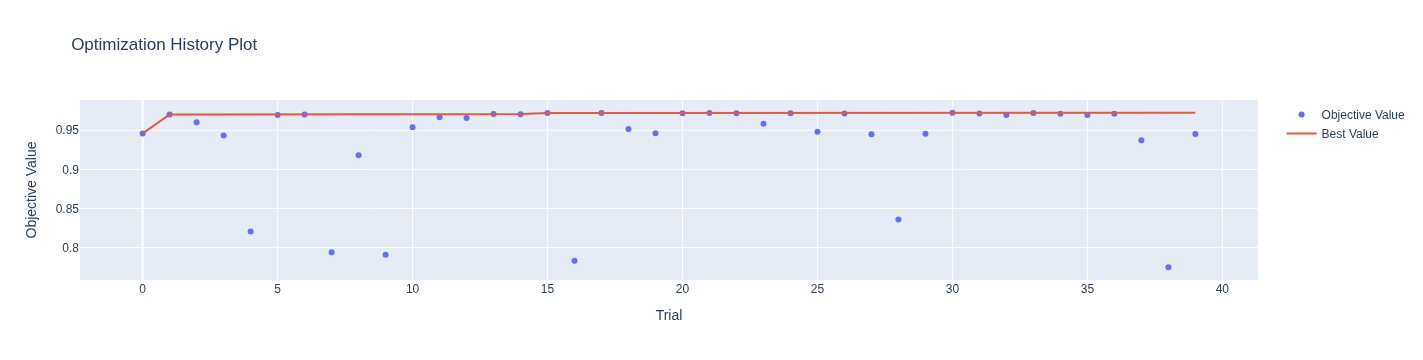

In [43]:
# Visualizar la optimización 
optuna.visualization.plot_optimization_history(study).show()

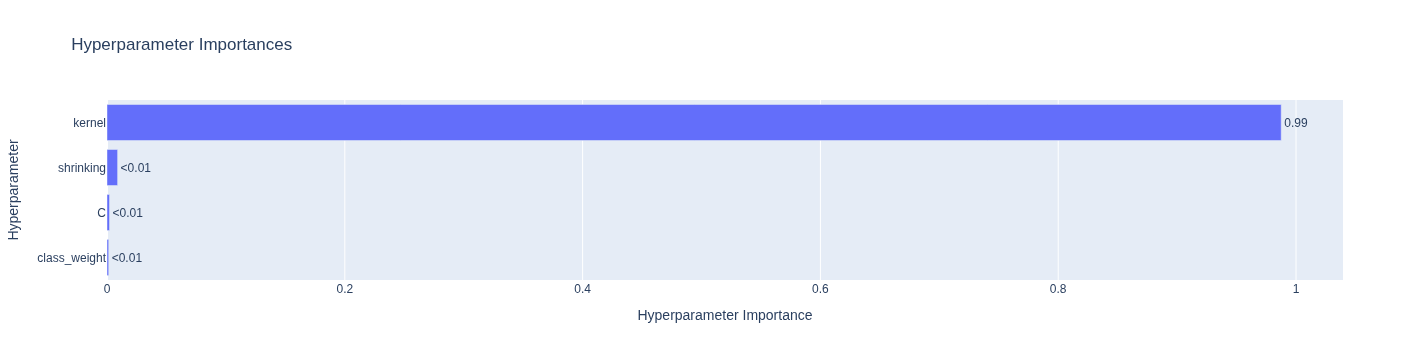

In [44]:
optuna.visualization.plot_param_importances(study).show()

In [59]:
best_trial = study.best_trial
scores = np.array(best_trial.user_attrs["cv_scores"])

print("\n" + "="*50)
print("INTERVALOR DE CONFIANZA Y DESVIACIÓN ESTÁNDAR")
print("="*50)

mean_score = np.mean(scores)
sem = st.sem(scores)  # error estándar
ci = st.t.interval(0.95, len(scores)-1, loc=mean_score, scale=sem)

print(f"Accuracy promedio: {mean_score:.3f}")
print(f"SEM: {sem:.3f}")
print(f"IC 95%: ({ci[0]:.3f}, {ci[1]:.3f})")


INTERVALOR DE CONFIANZA Y DESVIACIÓN ESTÁNDAR
Accuracy promedio: 0.972
SEM: 0.001
IC 95%: (0.969, 0.976)


In [60]:
print("\nEntrenando modelo final...")

# Preparar parámetros para el modelo final
final_params = {
    'C': best_params['C'],
    'kernel': best_params['kernel'],
    'random_state': 42,
    'probability': True
}

# Extraer gamma correctamente
if 'gamma_categorical' in best_params:
    final_params['gamma'] = best_params['gamma_categorical']
elif 'gamma_numeric' in best_params:
    final_params['gamma'] = best_params['gamma_numeric']

# Agregar degree si está presente (solo para kernel='poly')
if 'degree' in best_params:
    final_params['degree'] = best_params['degree']

# Agregar coef0 si está presente (para 'poly' y 'sigmoid')
if 'coef0' in best_params:
    final_params['coef0'] = best_params['coef0']

# Agregar shrinking si está presente
if 'shrinking' in best_params:
    final_params['shrinking'] = best_params['shrinking']

# Agregar class_weight si está presente
if 'class_weight' in best_params:
    final_params['class_weight'] = best_params['class_weight']

print("Parámetros finales configurados:")
for param, value in final_params.items():
    print(f"  {param}: {value}")

# Entrenar modelo con mejores parámetros
best_svm = SVC(**final_params)
best_svm.fit(X_train_scaled, y_train)
print("✓ Modelo entrenado exitosamente")    


Entrenando modelo final...
Parámetros finales configurados:
  C: 13.941534790676668
  kernel: rbf
  random_state: 42
  probability: True
  gamma: scale
  shrinking: True
  class_weight: balanced
✓ Modelo entrenado exitosamente


In [61]:
print("EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA")
print("="*50)

# Predicciones
y_test_pred = best_svm.predict(X_test_scaled)
y_test_pred_proba = best_svm.predict_proba(X_test_scaled)[:, 1]

# Calcular métricas
test_metrics = {
    'accuracy': accuracy_score(y_test, y_test_pred),
    'precision': precision_score(y_test, y_test_pred),
    'recall': recall_score(y_test, y_test_pred),
    'f1_score': f1_score(y_test, y_test_pred),
    'auc_roc': roc_auc_score(y_test, y_test_pred_proba),
    'specificity': recall_score(y_test, y_test_pred, pos_label=0),
    'mcc': matthews_corrcoef(y_test, y_test_pred)
}

print("Métricas en Prueba:")
for metric, value in test_metrics.items():
    print(f"{metric.upper()}: {value:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
print(f"\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Legítimo', 'Phishing']))

EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA
Métricas en Prueba:
ACCURACY: 0.9730
PRECISION: 0.9656
RECALL: 0.9810
F1_SCORE: 0.9732
AUC_ROC: 0.9966
SPECIFICITY: 0.9650
MCC: 0.9461

Classification Report (Test):
              precision    recall  f1-score   support

    Legítimo       0.98      0.96      0.97      1000
    Phishing       0.97      0.98      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



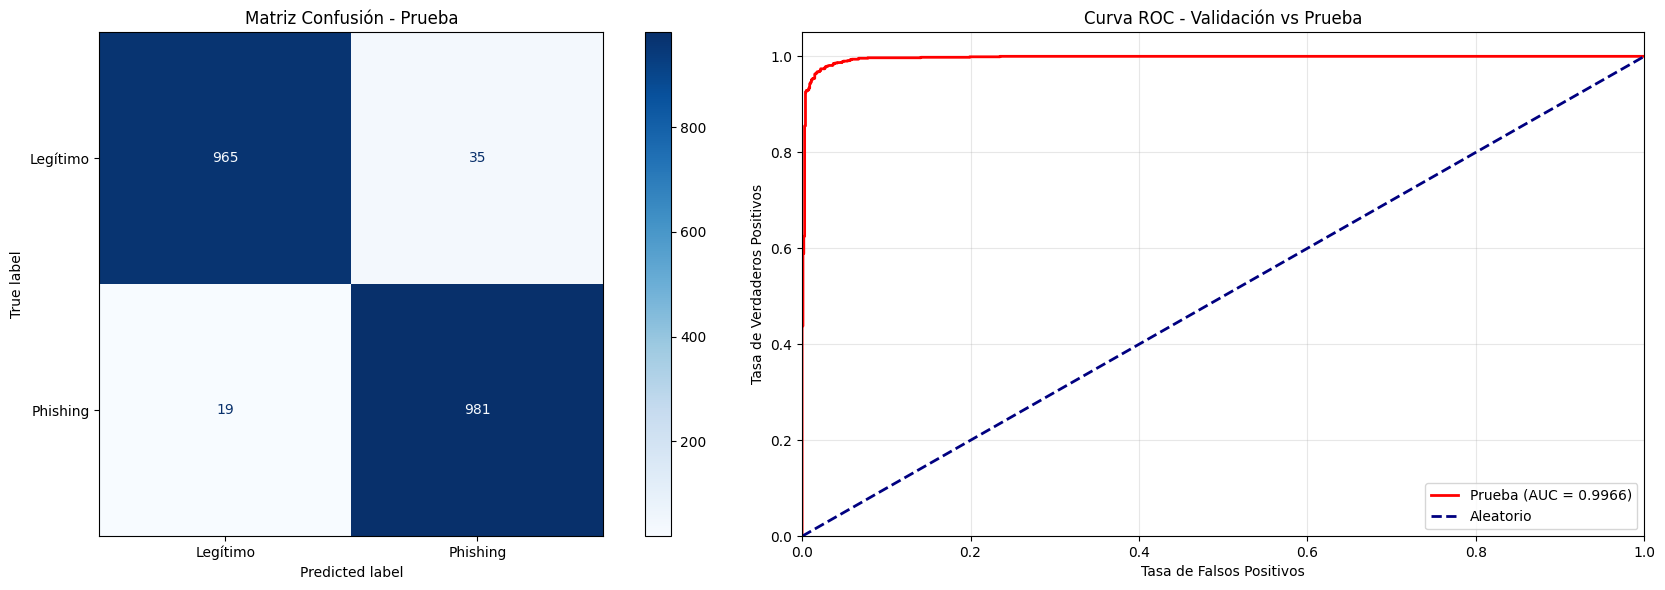

In [64]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)  # y_scores deben ser probabilidades, no clases
roc_auc = auc(fpr, tpr)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # ancho suficiente, altura reducida

# 2. Matriz de confusión - Prueba
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legítimo', 'Phishing'])
disp_test.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Matriz Confusión - Prueba')

# 3. Curva ROC combinada
axes[1].plot(fpr, tpr, color='red', lw=2, label=f'Prueba (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatorio')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos')
axes[1].set_ylabel('Tasa de Verdaderos Positivos')
axes[1].set_title('Curva ROC - Validación vs Prueba')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
